In [1]:
import json, pickle
import re
import warnings
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy.stats import spearmanr, kendalltau
from scipy.special import expit
from scipy import sparse as sp

warnings.filterwarnings("ignore")

In [2]:
# Load data from pickle

tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players = pickle.load(open('data/players.pkl', 'rb'))

In [3]:
def hasValidProperties(tournament_info):
    for team in tournament_info:
        team_mask = team.get('mask')
        team_members = [player['player']['id'] for player in team['teamMembers']]
        if team_mask is None or len(team_members) == 0:
            return False
    return True

In [4]:
# Clean results with invalid 'mask' and 'teamMembers' properties

results = {i : results[i] for i in results.keys() if hasValidProperties(results[i])}

# Split on train and test

train_results  = {i : results[i] for i in tqdm(results.keys()) if tournaments[i]['dateStart'][:4] == '2019'}
test_results  = {i : results[i] for i in tqdm(results.keys()) if tournaments[i]['dateStart'][:4] == '2020'}

100%|██████████| 3743/3743 [00:00<00:00, 1125799.92it/s]


In [5]:
players_names = {v['id']: f"{v['name']} { v['surname']}"  for _, v in players.items()}
tournament_names = {v['id']: v['name'] for _, v in tournaments.items()}

In [6]:
# To deal with 'X' and '?' and to keep all masks same size we simply replace them with 0

def toIntSafe(s):
    try:
        return int(s)
    except:
        return 0

# 2

In [7]:
temp_data = {
    'tournament_id': [],
    'team_id': [],
    'player_id': [],
    'question_id': [],
    'answer': []
}

for tournament_id, result in tqdm(train_results.items()):
    for team in result:
        for player in team['teamMembers']:
            for idx, ans in enumerate(team['mask'], start=1):
                temp_data['tournament_id'].append(tournament_id)
                temp_data['team_id'].append(team['team']['id'])
                temp_data['player_id'].append(player['player']['id'])
                temp_data['question_id'].append(idx)
                temp_data['answer'].append(toIntSafe(ans))

df = pd.DataFrame.from_dict(temp_data)


100%|██████████| 657/657 [00:11<00:00, 54.95it/s] 


In [8]:
df['avg_tournament'] = df.groupby(['tournament_id']).answer.transform('mean')
df['avg_question'] = df.groupby(['tournament_id', 'question_id']).answer.transform('mean')

In [9]:
ohe = OneHotEncoder().fit(df['player_id'].to_frame())

In [10]:
X_train = hstack([csr_matrix(df.drop(columns = ['tournament_id', 'team_id', 'player_id', 'question_id', 'answer']).values),
        ohe.transform(df['player_id'].to_frame())])
y_train = df['answer']

In [11]:
lr = LogisticRegression(solver = 'saga', n_jobs=-1).fit(X_train, y_train)

In [12]:
lr.coef_

array([[ 0.36452775,  5.62392998, -0.08722038, ..., -1.04267457,
        -0.03923824,  1.26032571]])

In [13]:
unique_players = np.unique(df['player_id'])
unique_questions = np.unique(df['question_id'])
                    
rating = pd.DataFrame({'player_id': unique_players,
                       'strength': lr.coef_[0][:len(unique_players)]})
rating['name'] = rating['player_id'].map(players_names)

In [14]:
rating.sort_values(by='strength', ascending=False).head(30).reset_index()

,index,player_id,strength,name
0,1,16,5.623930,Азер Абасалиев
1,3828,27416,2.880139,Сергей Русявый
2,599,4281,2.832952,Ольга Брыль
3,4015,28763,2.806804,Лариса Окатьева
4,13229,121440,2.774966,Андрей Дудкин
5,51110,214858,2.752195,Арина Давыдова
6,51112,214860,2.752193,Данил Баранков
7,51111,214859,2.752192,Вадим Поносов
8,51114,214862,2.752192,Егор Екимов
9,51113,214861,2.752191,Альвина Сафарян


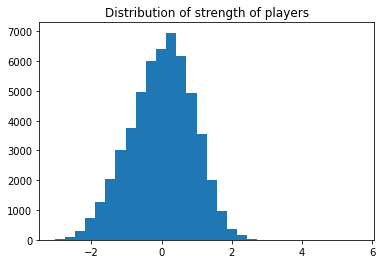

In [15]:
plt.hist(rating.strength, bins=30);
plt.title('Distribution of strength of players');

# 3

In [16]:
test_data = {
    'tournament_id': [],
    'team_id': [],
    'player_id': [],
    'question_id': [],
    'answer': []
}

for tournament_id, result in tqdm(test_results.items()):
    for team in result:
        for player in team['teamMembers']:
            for idx, ans in enumerate(team['mask'], start=1):
                if player['player']['id'] not in unique_players:
                    continue
                test_data['tournament_id'].append(tournament_id)
                test_data['team_id'].append(team['team']['id'])
                test_data['player_id'].append(player['player']['id'])
                test_data['question_id'].append(idx)
                test_data['answer'].append(toIntSafe(ans))

df_test = pd.DataFrame.from_dict(test_data)

100%|██████████| 386/386 [01:43<00:00,  3.74it/s]


In [17]:
df_test

,tournament_id,team_id,player_id,question_id,answer
0,4957,49804,30152,1,1
1,4957,49804,30152,2,1
2,4957,49804,30152,3,1
3,4957,49804,30152,4,1
4,4957,49804,30152,5,1
...,...,...,...,...,...
3679370,6456,63129,165962,35,0
3679371,6456,63129,165962,36,0
3679372,6456,63129,165962,37,0
3679373,6456,63129,165962,38,0


In [18]:
df_test['avg_tournament'] = df_test.groupby(['tournament_id']).answer.transform('mean')
df_test['avg_question'] = df_test.groupby(['tournament_id', 'question_id']).answer.transform('mean')

ohe_test = OneHotEncoder(handle_unknown='ignore').fit(df['player_id'].to_frame())

X_test = hstack([csr_matrix(df_test.drop(columns = ['tournament_id', 'team_id', 'player_id', 'question_id', 'answer']).values),
        ohe_test.transform(df_test['player_id'].to_frame())])
y_test = df['answer']

In [19]:
preds = lr.predict_proba(X_test)[:, 1]

In [20]:
def compute_scores(data, preds):
    data['pred'] = preds
    data['pred_answer'] = data.groupby(['tournament_id', 'team_id', 'question_id']).pred.transform(lambda x: 1 - np.prod(1 - x))
    data['real_score'] = data[['tournament_id', 'team_id', 'question_id', 'answer']].drop_duplicates().groupby(['tournament_id', 'team_id']).answer.transform('sum')
    data['pred_score'] = data[['tournament_id', 'team_id', 'question_id', 'pred_answer']].drop_duplicates().groupby(['tournament_id', 'team_id']).pred_answer.transform('sum')
    rating = data[['tournament_id', 'team_id', 'real_score', 'pred_score']].dropna().drop_duplicates().reset_index(drop=True)
    
    rating = rating.sort_values(by=['tournament_id', 'real_score'], ascending=False)
    rating['real_rank'] = rating.groupby('tournament_id')['real_score'].transform(lambda x: np.arange(1, len(x) + 1))

    rating = rating.sort_values(by=['tournament_id', 'pred_score'], ascending=False)
    rating['pred_rank'] = rating.groupby('tournament_id')['pred_score'].transform(lambda x: np.arange(1, len(x) + 1))
    
    print(f"Spearman: {rating.groupby('tournament_id').apply(lambda x: spearmanr(x['real_rank'], x['pred_rank']).correlation).mean()}")
    print(f"Kendall: {rating.groupby('tournament_id').apply(lambda x: kendalltau(x['real_rank'], x['pred_rank']).correlation).mean()}")


compute_scores(df_test, preds)


Spearman: 0.7390324986860242
Kendall: 0.5703063057315777


# 4

In previous model we made an assumption that if team answers a question than a member also answers. Actually it's not true.
So we will use strength of team. Let's assume that strngth of a team is a possibility of right answer of at least one of the members.
Strength of a team if a member answers right is 1.

like on previous step:

$$ P(team) = 1 - П[(1-P(member=1))]$$

In this case:

$$ P(team | member = 1) = 1 $$

$$ P(member = 1 | team) = \frac {P(team | member = 1) * P(member = 1)}{P(team)} = P(member = 1) / P(team) $$

$$ P(member = 1 | team = 0) = 0 $$ 


On E-step we calculate P(member = 1 | team)
On M-step we use LR on this target and find P(member=1)

In [21]:
def logLoss(y, y_pred):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [30]:
class EM:

    def __init__(self, w, n_iter = 100, verbose=False):
        self.w = w
        self.n_iter = n_iter
        self.verbose = verbose
    
    def _init_w(self, dim):
        self.w = np.random.randn(dim)
        
    def _E_step(self, data, preds):
        team_strength = pd.DataFrame({'team_id': data['team_id'],
                                      'question_id': data['question_id'], 
                                      'team_strength': 1 - preds})
        team_strength = team_strength.groupby(['team_id', 'question_id']).agg({'team_strength': 'prod'}).reset_index()
        team_strength['team_strength'] = 1 - team_strength['team_strength']
        team_strength = data[['team_id', 'question_id']].merge(team_strength)
        y = np.clip(preds / team_strength['team_strength'], 0, 1).values
        y[data['answer'] == 0] = 0
        return y
        
    def _M_step(self, X, y):
        model = LinearRegression()
        model.fit(X, y)
        self.w = model.coef_
                
    def fit(self, X_train, train_data, X_test, test_data):
        X_train = sp.hstack((np.ones((X_train.shape[0], 1)), X_train), format='csr')
        if self.w is None or len(self.w) != X_train.shape[1]:
            self._init_w(X_train.shape[1])
        
        for i in tqdm(range(self.n_iter)): 
            preds = self.predict(X_train)
            y = self._E_step(train_data, preds)
            y_mod = np.log(np.clip(y, 1e-6, 1-1e-6)/(1-np.clip(y, 1e-6, 1-1e-6)))
            self._M_step(X_train, y_mod)
            if i and self.verbose:
                compute_scores(test_data, self.predict(X_test))
                         
    def predict(self, X):
        if self.w is None:
            raise ValueError('not fitted')
        if len(self.w) != X.shape[1]:
            X = sp.hstack((np.ones((X.shape[0], 1)), X), format='csr')
        return expit(X.dot(self.w)) 
    
    
w_init = np.hstack([lr.intercept_, lr.coef_[0]])
em = EM(w_init, n_iter=5)

In [23]:

em.fit(
        X_train, 
        df, 
        X_test, 
        df_test)

100%|██████████| 5/5 [02:09<00:00, 25.85s/it]


In [24]:
compute_scores(df_test, em.predict(X_test))

Spearman: 0.7652588229347841
Kendall: 0.6147986758399568


Results seems to be better than baseline model

# 5

In [25]:
question_rating = dict(zip(unique_questions, em.w[-len(unique_questions):]))

df['difficulty'] = df['question_id'].map(question_rating)
df['tournament_name'] = df['tournament_id'].map(tournament_names)

tournaments_rating = df[['tournament_name', 'question_id', 'difficulty']].drop_duplicates()
tournaments_rating = tournaments_rating.groupby('tournament_name')['difficulty'].mean().sort_values(ascending=False).reset_index()

In [26]:
tournaments_rating.head(30)

,tournament_name,difficulty
0,Чемпионат Екатеринбурга и Свердловской области,-1.545788
1,Memel Cup,-1.557973
2,Чемпионат Мира. Этап 2. Группа А,-1.619128
3,Чемпионат Мира. Этап 3. Группа С,-1.619128
4,Чемпионат Кипра среди школьников,-1.619128
5,Чемпионат Мира. Финал. Группа А,-1.619128
6,Чемпионат Мира. Финал. Группа В,-1.619128
7,Чемпионат Мира. Финал. Группа С,-1.619128
8,Чемпионат Мира. Этап 1. Группа А,-1.619128
9,Чемпионат Мира. Этап 1. Группа В,-1.619128


In [27]:
tournaments_rating.tail(30)

,tournament_name,difficulty
611,Die Hard 2,-2.636015
612,Енисейская знать,-2.636015
613,Кубок молодёжи,-2.661603
614,Кубок Губернатора Мурманской области,-2.661603
615,Кубок Евразии,-2.661603
616,Студенческий Кубок княгини Ольги,-2.661603
617,Кубок малой Родины,-2.661603
618,Octobearfest,-2.661603
619,U-Mind Games – студенты,-2.661603
620,U-Mind Games – взрослые,-2.661603
